# 00.3 - bad compounds & inventorying

## Aim
1. Identify compounds with a "bad" absorbance trace that are unsuitable for later screening
2. Test Picklist design for multiple source and destination plates
3. Inventory screening consumables for planning screening operation

## Summmary
- Running all 980 Library compounds at 3 concentrations in buffer only

In [1]:
import re
from string import ascii_uppercase, ascii_lowercase
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('dark_background')
import seaborn as sns
import echo

# compound library
df = pd.read_csv('../../../data/lib/layouts.csv',index_col=0)
df.head()

,Item Name,CatalogNumber,SMILES,Rack Number,Plate Location
0,Axitinib,S1005,CNC(=O)C1=CC=CC=C1SC1=CC2=C(C=C1)C(\C=C\C1=CC=...,L1300-01,a1
1,Afatinib (BIBW2992),S1011,CN(C)C\C=C\C(=O)NC1=CC2=C(NC3=CC=C(F)C(Cl)=C3)...,L1300-01,b1
2,Bortezomib (Velcade),S1013,CC(C)C[C@H](NC(=O)[C@H](CC1=CC=CC=C1)NC(=O)C1=...,L1300-01,c1
3,Bosutinib (SKI-606),S1014,COC1=C(Cl)C=C(Cl)C(NC2=C(C=NC3=CC(OCCCN4CCN(C)...,L1300-01,d1
4,Dasatinib (BMS-354825),S1021,CC1=NC(NC2=NC=C(S2)C(=O)NC2=C(Cl)C=CC=C2C)=CC(...,L1300-01,e1


In [2]:
def mapWell384(well, xoff=0, yoff=0):
    '''
    map pipetting from 96 to 384 well plate, 
    given a multi-channel pipette and an offset
    '''
    assert re.search('[a-zA-Z][0-9]+', well) is not None
    let, num = re.search('([a-zA-Z])([0-9]+)', well).groups()
    let = ascii_uppercase[ascii_uppercase.index(let.upper()) * 2 + yoff]
    num = int(((int(num)-1) * 2) + 1 + xoff)
    return f'{let}{num}'

class WellArr:
    '''
    Construct for plotting plates
    '''
    def __init__(self):
        self.x = np.zeros((16,24))
    def __getitem__(self, idx):
        if isinstance(idx, str):
            if idx[0] in ascii_lowercase:
                i = ascii_lowercase.index(idx[0])
            if idx[0] in ascii_uppercase:
                i = ascii_uppercase.index(idx[0])
            j = int(idx[1:]) -1
            return self.x[i,j]
    def __setitem__(self, idx, new):
        if isinstance(idx, str):
            if idx[0] in ascii_lowercase:
                i = ascii_lowercase.index(idx[0])
            if idx[0] in ascii_uppercase:
                i = ascii_uppercase.index(idx[0])
            j = int(idx[1:]) -1
            self.x[i,j] = new
    def __len__(self):
        return len(self.x.flatten())


In [3]:
racks = {i:df.loc[df['Rack Number'] == i,:] for i in df['Rack Number'].unique()}

conc_grad = np.linspace(0.1,1,3)**2 * 0.05*40

dd = []

src_plates = []
dest_plates = []

for i in range(3):
    racks_ = list(racks)[i*4:i*4+4]
    d = {}
    src_ = echo.SrcPlate(ldv=True, name=f'src racks {i*4}..{i*4+4}')
    for rack, yoff, xoff in zip(racks_, [0,0,1,1], [0,1,0,1]):
        rack_df = racks[rack]
        for rackWell, catNum in zip(rack_df['Plate Location'], rack_df['CatalogNumber']):
            cpd = echo.Cpd(name=catNum, vol=100)
            srcWell = mapWell384(rackWell, xoff=xoff, yoff=yoff)
            src_[srcWell].fill(cpd.sample(12))
            d[srcWell] = cpd
    src_plates.append(src_)
    dd.append(d)
    
    destwells = (well for num in range(5) for well in echo.DestPlate(name=f'dest racks {i*4}..{i*4+4} {num}'))
    for srcwell in d:
        for destwell, vol in zip(destwells, conc_grad):
            src_[srcwell].xfer(destwell, vol)

## Plotting source plate transfers
This is a useful sanity check for me, else it can be hard to tell if all wells are transferring as I want

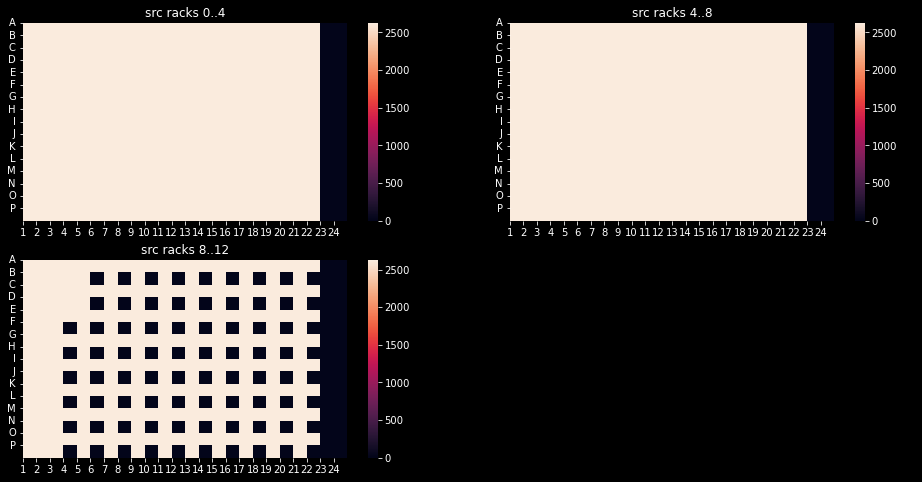

In [4]:
fig, ax = plt.subplots(2,2,figsize=(16,8))
for src_, ax_ in zip(src_plates, ax.flatten()):
    picklist = pd.DataFrame(src_.xfer_record).sort_values(['Destination Plate Name','SrcWell'])
    picklist = picklist.loc[picklist['Transfer Volume /nl'] != 0., :] # echo doesn't allow 0 nl
            
    x = WellArr()
    for i, j in zip(picklist.SrcWell, 
                    picklist['Transfer Volume /nl']):
        x[i] += j

    sns.heatmap(x.x, annot=False, ax=ax_, linecolor='black')
    ax_.set_title(src_.name)
    ax_.set_xticks(range(24), range(1,25))
    ax_.set_yticks(range(16), list(ascii_uppercase)[:16], rotation=0)

ax[1,1].axis('off')
plt.show()

## Plotting Destination Plates

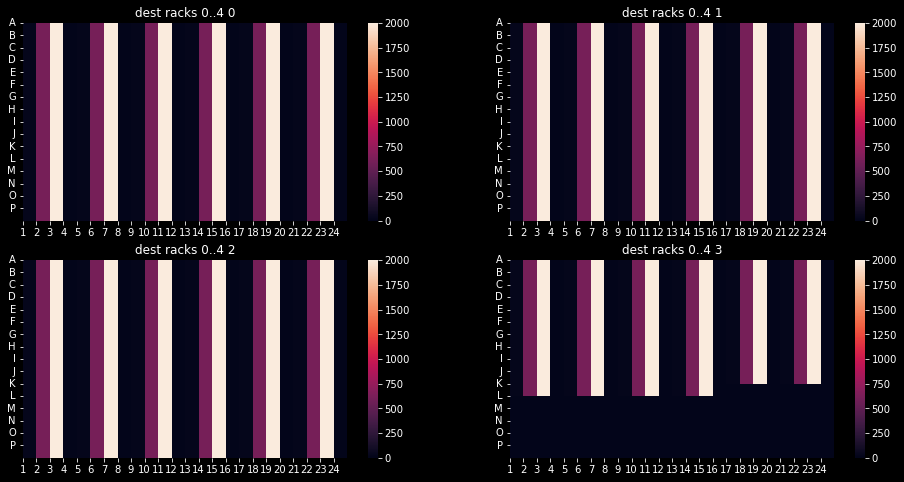

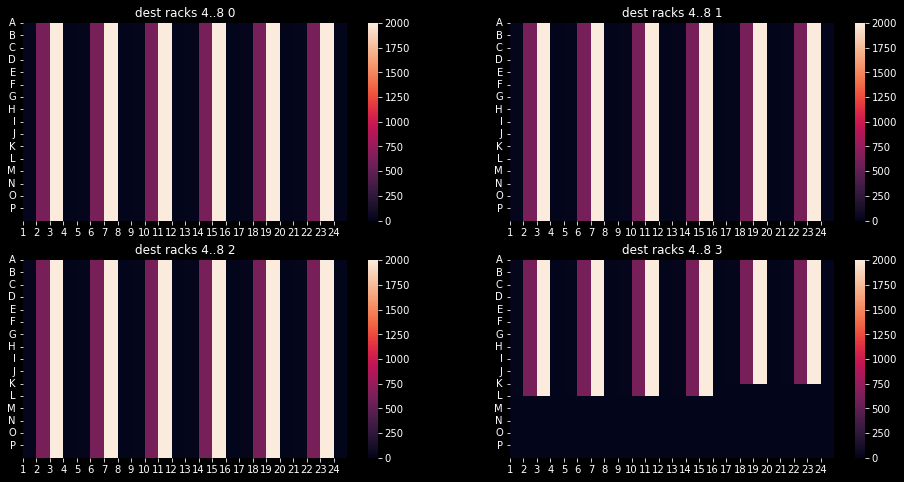

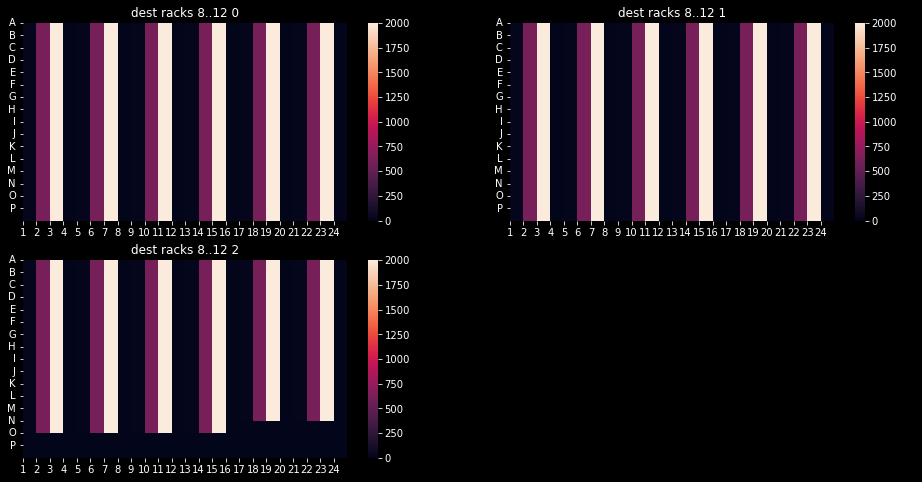

In [5]:
for src_ in src_plates:
    picklist = pd.DataFrame(src_.xfer_record).sort_values(['Destination Plate Name','SrcWell'])
    picklist = picklist.loc[picklist['Transfer Volume /nl'] != 0., :] # echo doesn't allow 0 nl
    fig, ax = plt.subplots(2,2,figsize=(16,8))
    for destPlate, ax_ in zip(picklist['Destination Plate Name'].unique(), ax.flatten()):
        picklist_ = picklist.loc[picklist['Destination Plate Name'] == destPlate,:]
            
        x = WellArr()
        for i, j in zip(picklist_.DestWell, 
                        picklist_['Transfer Volume /nl']):
            x[i] += j

        sns.heatmap(x.x, annot=False, ax=ax_)
        ax_.set_title(destPlate)
        ax_.set_xticks(range(24), range(1,25))
        ax_.set_yticks(range(16), list(ascii_uppercase)[:16], rotation=0)
        
ax[1,1].axis('off')
plt.show()

## Picklist
Combining all into one. 
The Echo should handle multiple source and destination plates ok.

In [6]:
picklists_ = []

for src_ in src_plates:
    picklist_ = pd.DataFrame(src_.xfer_record).sort_values(['Destination Plate Name','SrcWell'])
    picklist_ = picklist_.loc[picklist_['Transfer Volume /nl'] != 0., :] # echo doesn't allow 0 nl
    picklists_.append(picklist_)

picklist = pd.concat(picklists_).reset_index(drop=True)
picklist

,SrcPlate,Cpd,SrcWell,Destination Plate Name,DestWell,Transfer Volume /nl
0,src racks 0..4,[S1005],A1,dest racks 0..4 0,A1,20.0
1,src racks 0..4,[S1005],A1,dest racks 0..4 0,A2,605.0
2,src racks 0..4,[S1005],A1,dest racks 0..4 0,A3,2000.0
3,src racks 0..4,[S1199],A11,dest racks 0..4 0,G17,20.0
4,src racks 0..4,[S1199],A11,dest racks 0..4 0,G18,605.0
...,...,...,...,...,...,...
2929,src racks 8..12,[S4285],P7,dest racks 8..12 2,C14,605.0
2930,src racks 8..12,[S4285],P7,dest racks 8..12 2,C15,2000.0
2931,src racks 8..12,[S4314],P9,dest racks 8..12 2,D21,20.0
2932,src racks 8..12,[S4314],P9,dest racks 8..12 2,D22,605.0


In [7]:
picklist.to_csv('echo/picklists/2022-03-12-00.3-picklist.csv')

## runtime: 1h